# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import re
import pickle
import numpy as np
import pandas as pd

# import nltk
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import classfiers
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# import feature extraction, pipeline and model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
%matplotlib inline

import timeit

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('disaster_tweets', engine)
X = df['message']
y = df.drop(columns = ['id', 'message', 'original', 'genre'])

Let's have a look at the labels distribution.

In [3]:
pd.set_option('display.max_columns', 50)
df_desc = y.describe(include = 'all')
df_desc

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000,26028.00000,26028.000000,26028.000000,26028.000000,26028.000000,26028.000000
mean,0.764792,0.171892,0.004534,0.417243,0.080068,0.050446,0.027816,0.018096,0.033041,0.064239,0.112302,0.088904,0.015560,0.023206,0.011449,0.033618,0.045874,0.132396,0.065506,0.046143,0.051214,0.020440,0.006109,0.010873,0.004610,0.011872,0.044222,0.280352,0.082795,0.09386,0.010834,0.094321,0.020363,0.052866,0.194982
std,0.424137,0.377294,0.067180,0.493113,0.271403,0.218867,0.164449,0.133301,0.178748,0.245182,0.315744,0.284611,0.123768,0.150559,0.106389,0.180246,0.209215,0.338927,0.247422,0.209798,0.220438,0.141501,0.077921,0.103707,0.067745,0.108311,0.205591,0.449180,0.275578,0.29164,0.103525,0.292281,0.141240,0.223771,0.396195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_desc.sort_values(by='mean', axis=1, inplace=True, ascending=False)
lst = (df_desc.iloc[[1]]).values

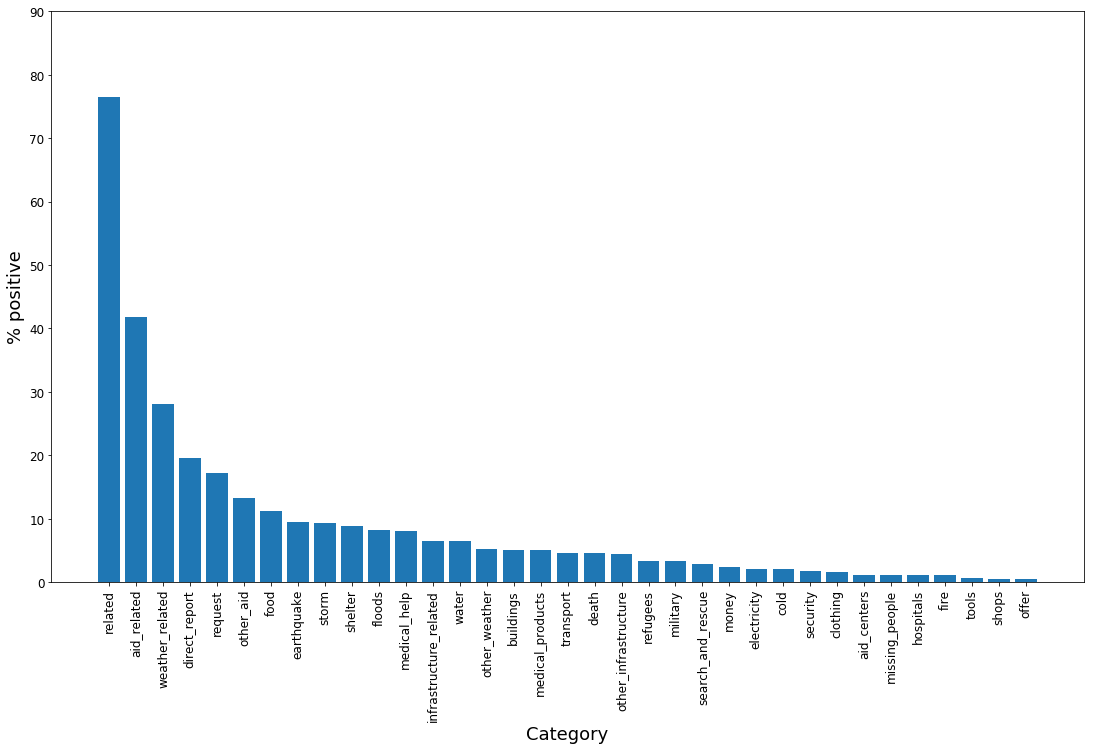

In [5]:
plt.bar(x = np.arange(35), height = lst[0]*100)
plt.ylabel("% positive", fontsize = 18)
plt.xlabel("Category", fontsize = 18)
plt.xticks(np.arange(35), df_desc.columns, rotation='vertical', fontsize = 12)
plt.yticks(np.arange(0,100,10), np.arange(0,100,10), fontsize = 12)
fig= plt.gcf()
fig.set_size_inches(18.5, 10.5)

Distribution of categories is unbalanced. This means that accuracy is not suitable as performance score. In this notebook precision, recall and f1 score will be used with macro averaging method to evaluate model predictions. Macro averaging means the scores for all labels are avaraged with the same weights as if the distribution was uniform. Additionaly ROC AUC score (Area Under the Receiver Operating Characteristic Curve) will be used.

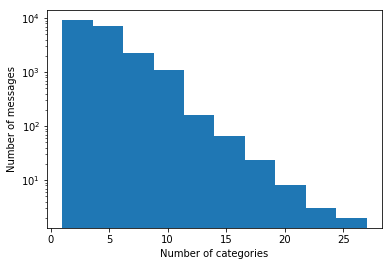

In [27]:
plt.hist(y[y['related']==1].sum(axis = 1))
plt.yscale('log', nonposy='clip')
plt.xlabel("Number of categories")
plt.ylabel("Number of messages")
plt.show()

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text): 
    # remove non-letter characters
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    # tokenize
    tokens = word_tokenize(text)
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
 
    return clean_tokens

In [4]:
class NounsExtractor(BaseEstimator, TransformerMixin):

    def get_nouns(self, text):
        sentence_list = nltk.sent_tokenize(text)
        nouns =[]
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            nouns = nouns + [word.lower() for word,pos in pos_tags if(pos == 'NN' or pos == 'NNS')]
        return ' '.join(nouns)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.get_nouns)
        return X_tagged

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [22]:
def build_cv(pipeline, parameters):

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, verbose = 5, n_jobs = -1, scoring = 'recall_weighted', refit = True,
                     return_train_score = False)
    
    return cv

In [6]:
def show_results(y_test, y_pred, print_report):
    f1 = []
    prcs = []
    recl = []
    rocauc = []
    for i, label in enumerate(y.columns):
        true = y_test[label].values
        pred = y_pred[label].values
        if print_report:
            print('Classification result for category \"{}\":'.format(label))
            print(classification_report(true, pred))
        f1.append((f1_score(true, pred, average = 'macro')))
        prcs.append(precision_score(true, pred, average = 'macro'))
        recl.append(recall_score(true, pred, average = 'macro'))
        rocauc.append(roc_auc_score(true, pred, average = 'macro'))

    return (pd.DataFrame.from_dict({'label':y.columns, 'precision':prcs, 'recall':recl, 'f1':f1, 'roc_auc':rocauc}))

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#### 4.1. Train "related" classifier

During data analysis it was shown that only messages which are labeled "related" contain other labels as well. One approach would be the following:
- First classfier will be trained for "related" label. This feature also has higher importance as it helps to filter out messages related to disaster.

- Second classifier will be trained for remaining labels to identify different labels for the categories based on experience with "related" classifier .

The "related" column is right-heavy:

([<matplotlib.axis.XTick at 0x7f4421d863c8>,
 <a list of 2 Text xticklabel objects>)

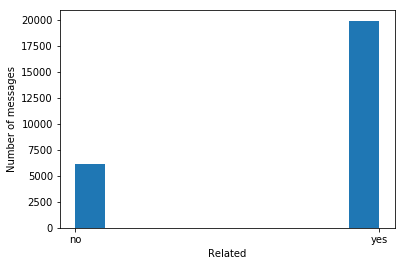

In [26]:
plt.hist(df['related']);
plt.xlabel("Related")
plt.ylabel("Number of messages")
plt.xticks(np.arange(0,2), ['no','yes'])

In [ ]:
df['related'].mean()

Dealing with imbalanced classes is complicated. To compensate for imbalance a function will be introduced to simply pad the underrepresented class until the proportion of minority class is in desired range.

In [7]:
def padToBalance(X, y):
    # find minority class
    if((y.sum() / y.shape[0]) > 0.5):
        minority = 0
    else:
        minority = 1
    # initialize outputs
    X_bal = X
    y_bal = y
    # pad the data until minority class is at least 25%
    while((y_bal == minority).sum() < 0.25 * y.shape[0]):
        X_bal = pd.concat([X_bal, X[y == minority]])
        y_bal = pd.concat([y_bal, y[y == minority]])
    
    return X_bal, y_bal

In [ ]:
X_train_bal, y_train_bal = padToBalance(X_train, y_train['related'])

MLPC_pipeline = Pipeline([
    #('noun', NounsExtractor()),
    ('vect', CountVectorizer(tokenizer = tokenize)),
    #('tfidf', TfidfTransformer()),
    ('clf', MLPClassifier(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
                           beta_2=0.999, early_stopping=True, epsilon=1e-8,
                           hidden_layer_sizes=(55), learning_rate='constant',
                           learning_rate_init=0.001, max_iter=200, momentum=0.9,
                           nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                           solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
                           warm_start=False))
])

MLPC_pipeline.fit(X_train_bal, y_train_bal)

In [ ]:
y_pred = MLPC_pipeline.predict(X_test)
true = y_test['related'].values
pred = np.squeeze(y_pred)
print(classification_report(true, pred))

In [ ]:
print('ROC AUC score (macro-averaged)', roc_auc_score(true, pred, average = 'macro'))
print('F1 score (macro-averaged)', f1_score(true, pred, average = 'macro'))

In [ ]:
MLPC_pipeline.named_steps['clf']

#### 4.2. Training categories classifiers

Training data needs to be balanced. Instead of a multi-output classifier we will use a dictionary of pipelines.

In [ ]:
MLPC_pipeline_dict = {}
countvec = CountVectorizer(tokenizer = tokenize)
start = timeit.default_timer()
for i,label in enumerate(y.columns):
    MLPC_pipeline_dict[label] = Pipeline([
        ('vect', countvec),
        ('clf',MLPClassifier(activation='relu', alpha=0.001, batch_size=200, beta_1=0.9,
                               beta_2=0.999, early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=55, learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200, momentum=0.9,
                               nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                               solver='adam', tol=0.01, validation_fraction=0.1, verbose=True,
                               warm_start=False))
    ])
    print('Training classifier {} of {} for \"{}\"'.format(i, len(y.columns), label))
    X_train_bal, y_train_bal = padToBalance(X_train, y_train[label])
    print(y_train_bal.sum()/y_train_bal.shape[0])
    MLPC_pipeline_dict[label].fit(X_train_bal, y_train_bal)
stop = timeit.default_timer()

MLPC_training_time = stop - start

In [ ]:
print('MLCP pipeline training time: {:.2f} seconds'.format(MLPC_training_time))

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
MLPC_pipeline_pred_dict = {}
start = timeit.default_timer()
for label in y.columns:
    MLPC_pipeline_pred_dict[label] = MLPC_pipeline_dict[label].predict(X_test)
stop = timeit.default_timer()
MLPC_predict_time = stop - start
    
y_pred = pd.DataFrame.from_dict(MLPC_pipeline_pred_dict)
results_MLPC = show_results(y_test, y_pred, print_report = False)
results_MLPC.mean()

In [ ]:
print('MLCP pipeline predict time: {:.2f} seconds'.format(MLPC_predict_time))

### 6. Improve your model
Use grid search to find better parameters. 

Grid search is computationally expensive, so it would be very time consuming to perform it on a multi output model. Also evaluation of multiple classifications will be complex. Instead grid search was applied to the "related" column in the section 4.1 to fine-tune MLPC parameters.

In [24]:
model_SVC = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize, ngram_range = (1,2), stop_words = 'english')),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(LinearSVC(class_weight = 'balanced', random_state = 1)))
    ])

parameters_SVC = {
    'clf__estimator__max_iter': [1000, 10000],
    'clf__estimator__class_weight': ['balanced', None]
}

lin_SVC_cv = build_cv(model_SVC, parameters_SVC)

start = timeit.default_timer()
lin_SVC_cv.fit(X_train, y_train)
stop = timeit.default_timer()
SVC_training_time = stop - start

print('Linear SVC pipeline grid search training time: {:.2f} seconds'.format(SVC_training_time))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000, score=0.44188445517665553, total=  24.7s
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000, score=0.4501853008808207, total=  21.6s
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   46.2s remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=1000, score=0.44475885503608986, total=  24.9s
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000, score=0.44188445517665553, total=  26.2s
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000, score=0.4501853008808207, total=  21.6s
[CV] clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__max_iter=10000, score=0.44475885503608986, total=  26.4s
[CV] clf__estimator__class_weight=None, clf__estimator__max_iter=1000 
[CV]  clf__estimator__class_weight=None, clf__estimator__max_iter=1000, score=0.34285273388363835, total=  14.8s
[CV] clf__estimator__class_weight=None, clf__estimator__max_iter=1000 
[CV]  clf__estimator__class_weight=None, clf__estimator__max_iter=1000, score=0.35126527341765273, total=  14.5s
[CV] clf__estimator__class_weight=None, clf__estimator__max_iter=1000 
[CV]  clf__estimator__class_weight=None, clf__estimator__max_iter=1000, score=0.3398264301191825, total=  14.3s
[CV] clf__estimator__class_weight=None, clf__estimator__max_iter=10000 
[CV]  clf__estimator__class_weight=None, clf__estimator__max_iter=

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.9min finished


Linear SVC pipeline grid search training time: 271.38 seconds


In [25]:
lin_SVC_cv.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        ...multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0),
           n_jobs=1))])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
show_results(y_test, y_pred, print_report = False)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

##### Random Forest 100 estimators

In [ ]:
model_RF = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators = 100, min_samples_split = 4)))
    ])

start = timeit.default_timer()
model_RF.fit(X_train, y_train)
stop = timeit.default_timer()

RF_training_time = stop - start

In [ ]:
print('RF pipeline training time: {:.2f} seconds'.format(RF_training_time))

In [ ]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_RF.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
RF_predict_time = stop - start
results_RF = show_results(y_test, y_pred, print_report = False)
results_RF.mean()

In [ ]:
print('RF pipeline predict time: {:.2f} seconds'.format(RF_predict_time))

##### Multinomial NB

In [ ]:
model_NB = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, stop_words = 'english')),
        ('clf', MultiOutputClassifier(MultinomialNB(fit_prior = False)))
    ])

start = timeit.default_timer()
model_NB.fit(X_train, y_train)
stop = timeit.default_timer()

NB_training_time = stop - start

print('NB pipeline training time: {:.2f} seconds'.format(NB_training_time))

In [ ]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_NB.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
NB_predict_time = stop - start
results_NB = show_results(y_test, y_pred, print_report = False)
results_NB.mean()

In [ ]:
print('NB pipeline predict time: {:.2f} seconds'.format(NB_predict_time))

##### Linear SVC

In [26]:
model_SVC = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize, ngram_range = (1,2), stop_words = 'english')),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(LinearSVC(class_weight = 'balanced', random_state = 1)))
    ])

start = timeit.default_timer()
model_SVC.fit(X_train, y_train)
stop = timeit.default_timer()
SVC_training_time = stop - start

print('Linear SVC pipeline training time: {:.2f} seconds'.format(SVC_training_time))

Linear SVC pipeline training time: 39.73 seconds


In [28]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_SVC.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
SVC_predict_time = stop - start
results_SVC = show_results(y_test, y_pred, print_report = True)
results_SVC.mean()

Classification result for category "related":
             precision    recall  f1-score   support

          0       0.64      0.58      0.61      1540
          1       0.87      0.90      0.89      4967

avg / total       0.82      0.82      0.82      6507

Classification result for category "request":
             precision    recall  f1-score   support

          0       0.94      0.91      0.93      5387
          1       0.63      0.71      0.67      1120

avg / total       0.89      0.88      0.88      6507

Classification result for category "offer":
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6484
          1       0.50      0.04      0.08        23

avg / total       0.99      1.00      0.99      6507

Classification result for category "aid_related":
             precision    recall  f1-score   support

          0       0.83      0.74      0.78      3828
          1       0.67      0.78      0.72      2679

avg / to

precision    0.727760
recall       0.703731
f1           0.707707
roc_auc      0.703731
dtype: float64

In [31]:
model_SVC.named_steps['clf']

MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0),
           n_jobs=1)

In [ ]:
print('Linear SVC pipeline predict time: {:.2f} seconds'.format(SVC_predict_time))

In [ ]:
all_results1 = results_SVC.join(results_MLPC, lsuffix = '_SVC', rsuffix = '_MLPC').drop(columns = ['label_MLPC']).rename(columns = {'label_SVC':'label'})
all_results2 = results_NB.join(results_RF, lsuffix = '_NB', rsuffix = '_RF').drop(columns = ['label_RF'])
all_results = all_results1.join(all_results2).drop(columns = ['label_NB'])
all_results[['label','roc_auc_SVC','roc_auc_MLPC','roc_auc_NB','roc_auc_RF']]

##### Using only nouns from the messages to reduce vocabulary.

Let's have a look of the vocabulary size with different parameters:

In [ ]:
print('Vocabulary length with stop words: ', len(MLPC_pipeline.named_steps['vect'].vocabulary_))
print('Vocabulary length without stop words: ', len(model_NB.named_steps['vect'].vocabulary_))
print('Vocabulary length without stop words with 1- and 2-word n-grams: ', len(model_SVC.named_steps['vect'].vocabulary_))

Let's use NounExtractor from section 2. to extract nouns from the data.

In [ ]:
X_train_N = NounsExtractor().transform(X_train)

In [ ]:
countVectorizer = CountVectorizer(tokenizer=tokenize)
countVectorizer.fit_transform(X_train_N)
print('Vocabulary length with only nouns: ', len(countVectorizer.vocabulary_))

Let's fit SVC model with the only nouns training data.

In [ ]:
start = timeit.default_timer()
model_SVC.fit(X_train_N, y_train)
stop = timeit.default_timer()

In [ ]:
print('Vocabulary length only nouns without stop words with 1- and 2-word n-grams: ',
      len(model_SVC.named_steps['vect'].vocabulary_))

In [ ]:
start = timeit.default_timer()
y_pred = pd.DataFrame(model_SVC.predict(X_test), columns = y.columns)
stop = timeit.default_timer()
SVC_predict_time = stop - start
results_SVC_N = show_results(y_test, y_pred, print_report = False)
results_SVC_N.mean()

### 9. Export your model as a pickle file

In [ ]:
f = open('model_MLPC.pickle','wb')
pickle.dump(MLPC_pipeline_dict, f)
f.close()

In [ ]:
f = open('model_RF.pickle','wb')
pickle.dump(model_RF, f)
f.close()

In [ ]:
f = open('model_NB.pickle','wb')
pickle.dump(model_NB, f)
f.close()

In [ ]:
f = open('model_SVC.pickle','wb')
pickle.dump(model_SVC, f)
f.close()

##### Comparing the models:

In [ ]:
model_scores = [results_SVC['roc_auc'].mean(), results_MLPC['roc_auc'].mean(),
                results_RF['roc_auc'].mean(), results_NB['roc_auc'].mean()]
model_sizes = [37.5, 1590.0, 1020.0, 29.8]
model_training = [SVC_training_time, MLPC_training_time, RF_training_time, NB_training_time]
model_comparison = pd.DataFrame.from_dict({'classifier':['Linear SVC',  'MLPC', 'RF', 'Multinomial NB'], 'ROC AUC':model_scores, 
                                          'size, MB':model_sizes, 'training time, s':model_training})

In [ ]:
model_comparison

Remarkably simpler models such as multinomial naive bayes and linear support vector classification have shown similar or higher performance comparing to more complex models such as multilayer perceptron and random forest.
<br>
This may be due to the fact, that twitter messages are short, so simple analysis methods are sufficient. 

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.